In [1]:
import re
def create_qadict_from_pdf(list):
    qlist = '(What|Where|When|Why|How|Who|Which)'
    qmatch = re.compile(qlist + '.*\?')
    #amatch = re.compile()
    lastansmatch = re.compile('(.*)\\n.*(Medication Guide|Manufactured|Distributed|Novartis).*',re.DOTALL)
    a = ""
    mydict = {}
    q = None
    for line in list:
        if qmatch.match(line.get_text()):
            if q != None:
                mydict[q] = a
            q = line.get_text()
            a = ""
            print(line.get_text())
        else:    
            if q != None:
                a += line.get_text()
    m = lastansmatch.match(a)
    ans = None
    while (m != None):
        ans = m.group(1)
        m = lastansmatch.match(m.group(1))
 
    if ans:
        mydict[q] = ans
    else:
         mydict[q] = a
    #print(mydict)
    return mydict

In [2]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import HTMLConverter
from pdfminer.layout import LAParams, LTTextBox, LTTextLine, LTFigure, LTChar, LTAnno, LTLine, LTCurve
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.pdfparser import PDFSyntaxError
OUTPUT_FOLDER = 'output'
def download_pdf(url, OUTPUT=OUTPUT_FOLDER):
    if not os.path.exists(OUTPUT):
        os.makedirs(OUTPUT)

    r = requests.get(url)

    drug_name = url.split('/')[-1]
    output_file_name = os.path.join(OUTPUT, drug_name)
    if not os.path.exists(output_file_name):
        with open(output_file_name, 'wb') as f:
            f.write(r.content)
    return output_file_name, drug_name

def parse_layout(layout, mytext, line_list):
    """Function to recursively parse the layout tree."""
    #mytext = []
    line = ""
    for lt_obj in layout:
        #print(lt_obj.__class__.__name__)
        #print(lt_obj.bbox)
        if isinstance(lt_obj, LTTextLine):
            mytext.append(lt_obj) #.get_text())
            #print(lt_obj.get_text())
            #print(text)
        elif isinstance(lt_obj, LTLine):
            line_list.append(lt_obj)
        elif isinstance(lt_obj, LTCurve):
            bbox = lt_obj.bbox
            if bbox[1] == bbox[3]:
                line_list.append(lt_obj)
        elif isinstance(lt_obj, LTTextBox): #or isinstance(lt_obj, LTTextLine):
            #print(lt_obj.get_text())
            mytext, line_list = parse_layout(lt_obj, mytext, line_list)  # Recursive
            
        #elif isinstance(lt_obj, LTAnno):
            #print(line)
           # print(str(lt_obj._text) + 'xx')
           # if lt_obj._text == '\n':
            #    text.append(line)
            #print(str(type(lt_obj)) + " : " + str(lt_obj.get_text()))
        #print(dir(lt_obj))
    #print(mytext)
    return mytext, line_list

def read_pdf_by_line(pdfpath):
    rsrcmgr = PDFResourceManager()
    codec = 'utf-8'
    laparams = LAParams()
    fp = open(pdfpath, 'rb')
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    listout = []
    line_list = []

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
        layout = device.get_result()
        #print(parse_layout(layout))
        listout, lines = parse_layout(layout, listout, line_list)
        # lines = parse_lines(layout)

        #print(listout)
    device.close()
    
    return listout, lines

In [3]:
from bs4 import BeautifulSoup as bs
import requests
import json
import pdfminer
from pdfminer.pdfparser import PDFSyntaxError
import os
ROOT_URL = 'https://www.pharma.us.novartis.com/product-list'


def page_soup(url):
    """return a soup object"""
    html = requests.get(url).text
    return bs(html, 'html.parser')


def get_pdf_hrefs():
    pdf_href_list = []  # {page_num: [BULAs URIs]}
    soup = page_soup(ROOT_URL)

    pdf_link_list = soup.findAll('a', text='Medication guide')
    pdf_href_list += [href.get('href') for href in pdf_link_list]
    return pdf_href_list




def dump_dict_to_json_file(dict_, file_name):
    with open(file_name, 'w') as fp:
        json.dump(dict_, fp, indent=4)


if __name__ == '__main__':

    print('\nscraping medication hrefs ... ')
    # scrape urls of medication list
    pdf_hrefs = get_pdf_hrefs()
    print(pdf_hrefs)
    
    # scrape and extract info of each bula, i.e. name, page link, and download pdf link
    
    # store output to a json file
    output_json_name = "drug_links.json"
    #dump_dict_to_json_file(BULAs, output_json_name)
    drugdict = {}
    for pdf in pdf_hrefs:
        pdfpath, drugname = download_pdf(pdf)
        drugname = drugname.split('_')[0]
        try:
            list, _ = read_pdf_by_line(pdfpath)
            drugdict[drugname] = create_qadict_from_pdf(list)
        except PDFSyntaxError as err:
            print("pdf at: " + pdf + " is invalid")
    print(drugdict)


scraping medication hrefs ... 
['https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/cosentyx_pmg.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/cosentyx_pmg.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/extavia_pmg.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/farydak_pmg.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/focalin_PPI.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/focalinXR_PPI.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/gilenya_pmg.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/ilaris_ppi.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/kymriah_pmg.pdf', 'https://www.pharma.us.novartis.com/sites/www.pharma.us.novartis.com/files/myfortic_pmg.pdf', 'https://www.pharma.us.novartis.c

In [81]:
questions = ['importantinfo', 'whatusedfor', 'howtouse', 'sideeffects', 'ingredients', 'whotakes', 'doctoradvice',
             'storage', 'interactions']
i = iter(drug.values() for drug in drugdict.values())
k = iter(drug.keys() for drug in drugdict.values())
drugs = iter(drug for drug in drugdict.keys())
mytree = {}
mydict = {}


# i = drug.values() for drug in drugdict.values()
# k = drug.keys() for drug in drugdict.values()
def splitanswer(a, mytree, tree, question):
    lasttitle = ''
    setlasttitle = False
    setnextinner = False
    mytree[drug][question] = {}
    tree = tree.add(question)
    m = re.compile("(.*)if you(.*)")

    for answers in re.split('(:)', a):
        if answers == (':'):
            setlasttitle = True
            #setnextinner = False
        asplit = re.split('(\uf0b7)|(\u2022)|( o )|(\\no )|([1-9]\.)', answers)
        answlen = len(asplit)
        if answlen > 1:
            for inner in asplit:
                if inner == None:
                    continue
                elif (inner == '\uf0b7') or (inner == '\u2022') or (inner == ' o ') or (inner == '\no '):
                    setnextinner = True
                    #setlasttitle = False
                    # print('note the following' + inner)
                    continue
                elif setlasttitle:
                    setlasttitle = False
                    if lasttitle != '':
                        try:
                            idx = lasttitle.strip('.').rindex('. ') + 2
                        except ValueError:
                            idx = 0

                        tree = tree.add('title')

                        if m.search(lasttitle,idx):
                            print("\033[31m last title question grouping\033[00m " + m.search(lasttitle[idx:]).group(
                                1))
                            tree.parent.data = m.search(lasttitle,idx).group(1)
                            tree.nodetype = 1
                        tree.data = lasttitle[idx:]
                    # mytree[drug]['info']['inner']
                    # lasttitle.rindex('. ')
                if setnextinner:
                    setnextinner = False
                    if (inner != "") and (inner != '\n'):
                        print('\033[31m inner\033[00m' + inner)
                        try:
                            mytree[drug][question]['inner'].append(inner)
                        except KeyError:
                            mytree[drug][question] = {}
                            mytree[drug][question]['inner'] = [inner]
                        innertree = tree.add('inner')
                        #if m.search(inner):
                            #print("\033[31m inner question grouping\033[00m " + m.search(inner).group(1))
                            #innertree.parent.nodetype = 1
                            #innertree.parent.data = m.search(inner).group(1)
                        innertree.data = inner

                # else:
                # print('inner title ' + inner)
                lasttitle = inner
        else:
            if not setlasttitle:
                print("\033[31m qtitle\033[00m " + answers)
                if m.match(answers):
                    print("\033[31m qtitle question grouping\033[00m " + m.match(answers).group(1))
                    data = m.match(answers).group(1)
                    try:
                        idx = data.strip('.').rindex('. ') + 2
                    except ValueError:
                        idx = 0
                    tree.data = data[idx:]
                    tree = tree.add('qtitle')
                    tree.data = m.match(answers).group(2)
                    tree.nodetype = 1
        # lasttitle = inner


In [82]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk

stopWords = set(stopwords.words('english'))


class Tree:
    """A tree implementation using python's autovivification feature."""

    def __init__(self, name='default'):
        self.name = name
        self.node = []
        self.otherInfo = None
        self.parent = None
        self.data = ""
        self.lastsibling = 0
        self.nodetype = 0

    def draw(self):
        out = self.name + '\n'
        for child in range(0, len(self.node)):
            print(self.node[child].name)
            out += '/' + ' '.join(['' for i in range(0, len(self.node[child].name) + 1)])
        out += '\n'
        for child in range(0, len(self.node)):
            out += self.node[child].__repr__()
        return out

    def nex(self, child):
        "Gets a node by number"
        return self.node[child]

    def incrementlastsibling(self):
        if len(self.node) > self.lastsibling + 1:
            self.lastsibling += 1
            return True
        else:
            return False

    def getnextsibling(self):
        if len(self.parent.node) > self.parent.lastsibling:
            tree = self.parent.nex(self.parent.lastsibling)
            self.parent.incrementlastsibling()
            return tree
        else:
            return self

    def getnextuncle(self):
        if len(self.uptree().uptree().node) > self.uptree().uptree().lastsibling:
            return self.uptree().getnextsibling()
            # return parent.nex(self.uptree().lastsibling)
        else:
            return self.parent

    def uptree(self):
        if self.parent != None:
            return self.parent
        else:
            raise ValueError(self.name + " has no parent node")

    def goto(self, name):
        "Gets the node by name"
        for child in range(0, len(self.node)):
            if (self.node[child].name == name):
                return self.node[child]
        else:
            try:
                if self.name != 'root':
                    tree = self.uptree()
                    return tree.goto(name)
                else:
                    raise ValueError(name + " node not found")
            except ValueError:
                print(name + ' not found')
                raise ValueError(self.name + " has no parent node")

    def info(self):
        for child in range(0, len(self.node)):
            print("\033[31m " + self.node[child].name + ": \033[00m " + self.node[child].data + "\t")
            self.node[child].info()

    def moresiblingsexist(self):
        if self.parent.lastsibling  < len(self.parent.node):
            return True
        else:
            return False

    def nextdata(self):
        out = ''
        if self.nodetype == 0:

            # for child in range(0, len(self.node)):
            # if self.node[child].data != '' and self.node[child].data != '\n':
            # if self.data != '' and self.data != '\n':
            # out = self.data
            if len(self.node) > 0 and self.node[self.lastsibling].data != '' and self.node[
                self.lastsibling].data != '\n':
                # out += str(self.node[child].nextdata())
                out += str(self.node[self.lastsibling].data)
                #if out != '':
                tree = self.node[self.lastsibling]
                self.incrementlastsibling()
                #if self.incrementlastsibling():
                #    out += "\nWould you like more detail?"
                #else:
                #    out += "\nThat's all the details. Is there anything else?"
                return tree, out
            else:
                try:
                    tree = self.nex(0)
                    return tree.nextdata()
                except IndexError:
                    if self.data == '' or self.data == '\n':
                        return self, "\nI have no further information. What else can I help you with?"
                    else:
                        return self, self.data
        else:
            # get next child

            if str(self.node[self.lastsibling].data) != '':
                out = '\nDo you ' + str(self.node[self.lastsibling].data.strip('\n')) + '?'

            else:
                return self.nextdata()
            self.incrementlastsibling()
            return self, out

    def add(self, name):
        node1 = Tree(name)
        self.node.append(node1)
        node1.parent = self
        return node1

    # def traverse(self):

    def __missing__(self, key):
        value = self[key] = type(self)()
        return value


class Pharmabot:
    drug = ''
    drugtries = 0
    qtype = 0
    question = None
    previousqn = None
    answer = ''
    strike1 = False
    tree = Tree()

    def __init__(self, drugdict, drug='', qtype=0):
        self.drugdict = drugdict
        self.drug = drug
        self.drugtries = 0
        self.qtype = qtype

    def __repr__(self):
        return ', '.join(
            ['drug:', self.drug, 'drugtries:', str(self.drugtries), 'question:', str(self.question), 'answer:',
             self.answer])

    def getapptext(self, usertext):
        words = word_tokenize(usertext)
        drugexists, drug = self.checkdrug(self.drugdict, words)
        qn = self.parsequestion(usertext)

        if qn != None:
            self.previousqn = self.question
            self.question = qn
        print(self.question)
        if (not drugexists) and (self.drug == ''):
            self.drugtries += 1
        elif drugexists:
            self.drug = drug
            self.tree = self.drugdict[drug]
            self.drugtries = 0
        self.answer = self.replyqn()
        return '\033[31m' + str(self.answer) + '\033[00m\n'

    def replyqn(self):
        #print('q: ' + str(self.question))
        if (self.drug != '') and (self.question != None) and (self.question != ''):
            if (self.question != 'no') or (self.tree.parent.nodetype == 1):
                self.strike1 = False
            if (self.question == 'no') and (self.tree.parent.nodetype == 1):
                self.question = self.previousqn
                try:
                    self.tree = self.tree.getnextsibling()
                    out = self.tree.data
                    # out += self.tree.nextdata()
                    tree, moreout = self.tree.nextdata()
                    self.tree = tree
                    if moreout != '':
                        out = moreout
                    return out
                except:
                    self.tree.nodetype == 0
                    return "Do you have any other questions?"
            elif (self.question == 'yes') and (self.tree.parent.nodetype == 1):
                self.question = self.previousqn
                self.tree = self.tree.uptree()
                out = self.tree.data
                # out += self.tree.nextdata()
                if out == '' or out == '\n':
                    tree, moreout = self.tree.nextdata()
                    self.tree = tree
                    out = moreout

                else:
                    out += "\nIs there anything else?"
                return out
            elif (self.question == 'yes') and (self.tree.parent.nodetype == 0):
                self.question = self.previousqn
                try:
                    # self.tree = self.tree.getnextuncle()
                    self.tree = self.tree.getnextsibling()
                    out = self.tree.data
                    # out += self.tree.nextdata()
                    tree, moreout = self.tree.nextdata()
                    self.tree = tree
                    if out != moreout:
                        out += moreout

                    if self.tree.moresiblingsexist():
                        out += "\nWould you like more detail?"
                    else:
                        out += "\nI have no further information. What else can I help you with?"

                    return out
                except:
                    self.tree.nodetype == 0
                    return "Do you have any other questions?"

            elif (self.question == 'no') and (self.tree.parent.nodetype == 0):
                self.question = self.previousqn
                if self.strike1:
                    return "Nice talking with you. Bye"
                self.strike1 = True
                return "Ok, is there anything else I can help with?"
            else:
                try:
                    self.tree = self.tree.goto(self.question)
                    out = self.tree.data
                    # out += self.tree.nextdata()
                    tree, moreout = self.tree.nextdata()
                    self.tree = tree
                    if tree.nodetype != 1:
                        out += moreout
                    else:
                        out = moreout
                    if self.tree.moresiblingsexist():
                        if tree.nodetype != 1:
                            out += "\nWould you like more detail?"
                        #else:
                           # out = "\nDo you " + out + " ?"
                    else:
                        out += "\nThat's all the details. Is there anything else?"

                    return out
                except ValueError:
                    return "I don't have information on " + self.question + "\n Is there something else I can help with?"

        elif self.drugtries > 1:
            nodrugreply = 'You can ask about one of these: ' + ', '.join(drugdict.keys())
        elif self.question == None:
            return 'What would you like to know about ' + self.drug + '?'

        else:
            nodrugreply = 'Please enter the drugname'
        return nodrugreply

    # TO DO: replace this function with NLP
    def parsequestion(self, usertext):
        words = word_tokenize(usertext)
        if ('no' in words) and (len(words) < 4):
            return 'no'
        elif ('yes' in words) and (len(words) < 4):
            return 'yes'
        elif ('how' in words) and ('use' in words):
            return questions[2]
        elif ('who' in words) and (('use' in words) or ('take' in words)):
            return questions[5]

        elif ('what' in words) and ('use' in words):
            return questions[1]

        elif ('effects' in words) and ('side' in words):
            return questions[3]
        elif 'ingredients' in words:
            return questions[4]
        elif 'storage' in words:
            return questions[7]
        elif ('doctor' in words) or (('healthcare' in words) and ('practitioner' in words)):
            return questions[6]
        elif 'information' in words:
            return questions[0]

        else:
            return None

    def checkdrug(self, drugdict, words):
        drugs = iter(drug for drug in drugdict.keys())

        while (True):
            try:
                drug = next(drugs)
                if drug in words:
                    print(drug)
                    return (True, drug)
            except StopIteration:
                break
        return False, None


In [ ]:
for drug in drugs:
    # try:
    mytree[drug] = {}
    tree = mydict[drug] = Tree('root')
    tree.data = drug
    # except NameError:
    #    mytree = {}
    qlist = ['What', 'Where', 'When', 'Why', 'How', 'Who', 'Which']

    for q, a in zip(next(k), next(i)):
        # a = next(i)
        #words = word_tokenize(q)
        #qtype = qlist.index(words[0])
        # print(nltk.pos_tag(nltk.word_tokenize(a)))
        setlasttitle = False
        tokenlist = nltk.pos_tag(nltk.word_tokenize(q))
        qtype = qlist.index(tokenlist[0][0])

        for pairing in tokenlist:
            if pairing[0] not in stopWords:
                #pairing = (nltk.pos_tag(nltk.word_tokenize(w))[0])

                # (lambda x:
                try:

                    if (pairing[1] == 'VB') & (pairing[0] in ['use', 'take']) & (qtype == 4):
                        splitanswer(a, mytree, tree, questions[2])
                        print(questions[2], q)
                        break
                    elif (pairing[1] == 'VB') & (pairing[0] in ['use', 'take']) & (qtype == 5):
                        splitanswer(a, mytree, tree, questions[5])
                        print(questions[5], q)
                        break

                    elif (pairing[1] == 'VB') & (pairing[0] in ['use', 'take']) & (qtype == 0):
                        splitanswer(a, mytree, tree, questions[1])
                        print(questions[1], q)
                        break
                    elif (pairing[1] == 'NN') & (pairing[0] in ['information']) & (qtype == 0):
                        splitanswer(a, mytree, tree, questions[0])
                        print(questions[0], q)

                        break
                        # print(repr(a))
                    elif (pairing[1] == 'NN') & (pairing[0] in ['doctor', 'healthcare', 'practitioner']) & (qtype == 0):
                        splitanswer(a, mytree, tree, questions[6])
                        print(questions[6], q)
                        break
                    elif (pairing[1] == 'NNS') & (pairing[0] in ['ingredients', 'constituents']):
                        splitanswer(a, mytree, tree, questions[4])
                        print(questions[4], q)
                        print(a)
                        break
                    elif (pairing[1] == 'NNS') & (pairing[0] in ['effects', 'side-effects']):
                        splitanswer(a, mytree, tree, questions[3])
                        print(questions[3], q)
                        print(a)
                        break
                    elif ((pairing[1] == 'NN') & (pairing[0] in ['storage'])& (qtype == 0))|((pairing[1] == 'VB') & (pairing[0] in ['store']) & (qtype == 4)):
                        splitanswer(a, mytree, tree, questions[7])
                        print(questions[7], q)
                        print(a)
                        break
                    elif ((pairing[1] == 'NNS') & (pairing[0] in ['interactions'])) | ((pairing[1] == 'VB') & (pairing[0] in ['avoid'])) & (qtype == 0):
                        splitanswer(a, mytree, tree, questions[8])
                        print(questions[8], q)
                        print(a)
                        break

                    # else:
                    # print(w + ' dd' + pairing[1])
                except KeyError:
                    print(w + " not in dict")
                    # v2 if p2(x) else
                    # v3)
print('done')

 qtitle COSENTYX is a medicine that affects your immune system. COSENTYX may increase your risk of having serious 
side effects such as
 inner  Your healthcare provider should check you for tuberculosis (TB) before starting treatment with COSENTYX. 

 inner 
If your healthcare provider feels that you are at risk for TB, you may be treated with medicine for TB before you 
begin treatment with COSENTYX and during treatment with COSENTYX. 

 inner  Your healthcare provider should watch you closely for signs and symptoms of TB during treatment with 
COSENTYX. Do not take COSENTYX if you have an active TB infection. 
Before starting COSENTYX, tell your healthcare provider if you
 last title question grouping Before starting COSENTYX, tell your healthcare provider 
 inner  are being treated for an infection 

 inner  have an infection that does not go away or that keeps coming back  

 inner  have TB or have been in close contact with someone with TB 

 inner 
think you have an infection or 

 inner
loss of vision 
 inner weakness 

 inner  breathing problems. Some people who take GILENYA have shortness of breath. Call 
your doctor right away if you have trouble breathing. 

 inner 
liver problems. GILENYA may cause liver problems. Your doctor should do blood tests 
to check your liver before you start taking GILENYA. Call your doctor right away if you 
have any of the following symptoms of liver problems
 last title question grouping Call your doctor right away 
 inner nausea 
 inner vomiting 
 inner stomach pain  
 inner
loss of appetite 
 inner tiredness 
 inner your skin or the whites of your eyes turn yellow 
 inner dark urine 

 inner  skin cancers including basal cell carcinoma (BCC) and melanoma.  Talk to your 
doctor if you notice any skin nodules (e.g., shiny pearly nodules), patches or open 
sores that do not heal within weeks, or unusual moles, which may present as a change 
in color, shape, or size over time.   These may be signs of skin cancer. 
The most commo

interactions What should I avoid while taking ZORTRESS?  

  Avoid receiving any live vaccines while taking ZORTRESS. Some vaccines may not work as well while you are 
taking ZORTRESS. 
  Do not eat grapefruit or drink grapefruit juice while you are taking ZORTRESS. Grapefruit may increase your 
blood level of ZORTRESS. 
  Limit the amount of time you spend in the sunlight. Avoid using tanning beds or sunlamps. People who take 
ZORTRESS have a higher risk of getting skin cancer. See the section “What is the most important 
information I should know about ZORTRESS?” Wear protective clothing when you are in the sun and use a 
sunscreen with a high protection factor (SPF 30 and above). This is especially important if you have fair skin or 
if you have a family history of skin cancer. 
  Avoid becoming pregnant. See the section “What should I tell my doctor before taking ZORTRESS?” 

 qtitle ZORTRESS may cause serious side effects, including
 inner  See “What is the most important info

In [ ]:
import time
mybot = Pharmabot(mydict)
apptext = '\033[31m Hi\033[00m\n'
usertext = ''

def slowprint(astring):
    for letter in astring:
        print(letter,end='')
        time.sleep(0.05)
    return ''

while usertext.lower() != 'bye':

    usertext = input(slowprint(apptext))
    apptext = mybot.getapptext(usertext)



 Hi
cosentyx side effects
cosentyx
sideeffects
Get emergency medical help right away  
Inflammatory bowel disease. New cases of inflammatory bowel disease or “flare-ups” can happen with 
COSENTYX, and can sometimes be serious. If you have inflammatory bowel disease (ulcerative colitis or Crohn’s 
disease), tell your healthcare provider if you have worsening disease symptoms during treatment with COSENTYX 
or develop new symptoms of stomach pain or diarrhea. 

Would you like more detail?
yes
yes
  Serious allergic reactions. Get emergency medical help right away if you get any of the following symptoms of a 
feel faint 
serious allergic reaction
Would you like more detail?
yes
yes
Get emergency medical help right away if you get any of the following symptoms of a 
feel faint 
serious allergic reaction
Do you  swelling of your face, eyelids, lips, mouth, tongue, or throat  ?
Would you like more detail?
no
no
Ok, is there anything else I can help with?
no
no
Nice talking with you. Bye
foc

In [4]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)

D:\apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(0, 30)

In [64]:
from bs4 import BeautifulSoup as bs
import requests
import json
import pdfminer
from pdfminer.pdfparser import PDFSyntaxError
import os
import re
ROOT_URL = "https://www.drugs.com/answers/questions/"


def page_soup(url):
    """return a soup object"""
    html = requests.get(url).text
    return bs(html, 'html.parser')


def get_pdf_hrefs(url):
    pdf_href_list = []  # {page_num: [BULAs URIs]}
    soup = page_soup(url)

    pdf_link_list = soup.findAll('a')
    for link in pdf_link_list:
        if re.search('/answers/[^/]*\.html',link.attrs['href']):

            pdf_href_list.append(link.attrs['href'])
    return pdf_href_list




D:\apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


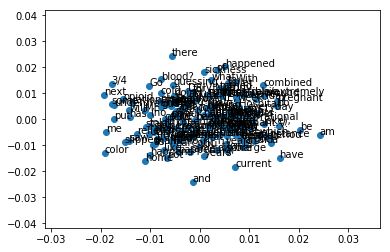

In [202]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [187]:
def get_sentences(url):
    base = "https://www.drugs.com"
    soup = page_soup(base + url)
    pat = re.compile('.*\(([0-9]+)\).*')
    resphead = soup.find('div', attrs={'class':'replyListHeader'})
    mat =re.match(pat, resphead.text.strip('\n'))
    postcontents = soup.find('div', attrs={'class':'postContent'})
    if postcontents:
        responses = [postcontents.text.replace('\n','')]
        if mat:
            num = int(mat.group(1))
            listcontents = soup.findAll('div', attrs={'class':'listContent'})
            responses += [listcontents[x].text.replace('\n','').strip('Votes:[+\-0-9] Comment Vote up Report') for x in range(1,num + 1)]
        return responses
    else:
        return[]

In [342]:

sentencelist = []
for url in href_list:
    try:
        sentencelist += get_sentences(url)
    except BaseException as error:
        print('An exception occurred: {}'.format(error))
        continue
#sentences += [sentencetokenize(sentence) for sentence in sentencelist]


An exception occurred: ('Connection aborted.', OSError("(10053, 'WSAECONNABORTED')",))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/neurontin-drug-prescribed-sciatic-nerve-joint-pain-3186587.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35908>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/orsythia-long-spotting-after-decided-orsythia-3186548.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35CC0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/normal-heavy-bleeding-day-8-taking-provera-3186455.html (Caused by NewConnection

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/anyone-stopped-restarted-victoza-work-time-before-3184629.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35B38>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/topiramate-mellowish-sleepish-highish-3184612.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35FD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/topiramate-mellowish-sleepish-highish-3184612.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A355C0>: Failed to establish

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/low-lithium-called-you-identify-someone-bipolar-3183340.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35E10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/atorvastatin-years-providers-knew-many-problems-3183321.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35048>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/atorvastatin-years-providers-knew-many-problems-3183321.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35908>: F

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/ethinyl-estradiol-norethindrone-yaz-started-4-3181186.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35B70>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/period-side-affect-depo-3181185.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35E10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/period-side-affect-depo-3181185.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A356A0>: Failed to establish a new connection: [Errno 11001]

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/start-seeing-results-aczone-3179551.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35048>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/proper-recommended-procedure-climara-patch-3179536.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35E10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/stop-diarrhea-medicine-remedy-suggestions-3179525.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35EF0>: Failed to establish a new connec

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/accutane-grandson-60mgs-day-he-into-3rd-month-due-3178068.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35E10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/accutane-grandson-60mgs-day-he-into-3rd-month-due-3178068.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42698CD30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/doxycycline-fatigue-sleepiness-normal-taking-doxy-3178060.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35B

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/birth-control-broken-condom-pull-method-plan-3177411.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35A90>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-side-effects-prolia-3177341.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35C88>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-side-effects-prolia-3177341.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35518>: Failed to establish a new connection: [Errno 11001

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/metformin-he-market-son-recently-prescribed-3176162.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35E10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/glass-wine-taking-cipro-3176130.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35908>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/adcirca-cialis-compare-tadalafil-differing-3176109.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35D68>: Failed to establish a new connecti

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/birth-control-sugar-pills-dark-green-sunday-3175184.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35B38>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/drink-alcohol-taking-epclusa-hepatitis-3175158.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35710>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/sprintec-switching-methods-3175154.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35048>: Failed to establish a new connectio

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/nuvaring-nr-sex-due-fact-bothers-bf-3174882.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35908>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/sex-friday-bought-plan-sunday-late-3174879.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35B00>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/miralax-long-after-you-you-start-pooping-3174876.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35E10>: Failed to establish a new connect

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/prescribed-dapsone-confused-instructional-3174037.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426A35320>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/microgestin-fe-1-5-30-microgestin-1-5-30-started-3174036.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/voltaren-gel-common-high-blood-pressure-gel-3174010.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSC

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/accidentally-200mg-tramadol-place-regular-meds-3173742.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/constipation-chronic-anyone-missed-work-due-3173731.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/plan-step-emergency-wanting-people-opinions-3173730.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/taking-orlistat-3-months-first-2-months-featured-3173471.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/taking-orlistat-3-months-first-2-months-featured-3173471.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/extra-strength-excedrin-6-day-meloxicam-provide-3173460.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/pregnant-3173142.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/pregnant-3173142.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/spiriva-handihaler-dr-gave-samples-cut-costs-3173127.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/polysporin-sting-burning-sensati

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/male-enhancement-drugs-safe-blood-pressure-3172847.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-effects-tramadol-3172823.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/nexplanon-sleep-arm-break-3172800.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/nexp

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-chlamydia-medication-absorbed-into-body-3172525.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/campral-impotence-3172513.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/campral-impotence-3172513.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/plan-step-brow

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/junel-fe-1-20-junes-de-1-20-recently-started-3172239.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/lichen-sclerosus-clobetasol-physician-administer-3172231.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/harvoni-expect-3172225.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/beginning-month-regular-cycle-bout-3-days-again-23-3171813.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/amantadine-influenza-many-years-ago-tested-every-3171812.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/bleed-every-time-sex-excited-3025371.html (Caused by SSLError(SSLError("bad handshake: SysCallError(10060, 'WSAETIMEDOUT')",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/mom-recently-

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/amlodipine-2-months-ago-suffered-anxiety-panic-3024839.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/left-home-7-days-left-3024824.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: ('Connection aborted.', OSError("(10053, 'WSAECONNABORTED')",))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/topamax-helped-weight-loss-far-3021363.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B9978>: Failed to establish a new connection: [Errno 11001] 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/safe-ttc-fertility-drug-kit-3021172.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B9400>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/ortho-tri-cyclen-over-pack-28-start-2-3021169.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B9F60>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/antibiotics-make-increased-vascular-permiability-3021159.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B9898>: Failed to establish a new conn

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/tri-lo-sprintec-switch-generic-ortho-after-3020764.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B9400>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/guaifenesin-someone-diabetes-3020749.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B99B0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/paxil-cr-increased-25-mg-50-mg-long-regain-happy-3020736.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B9588>: Failed to establish a ne

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/effexor-xr-3-months-withdrawing-3020170.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B9630>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/effexor-xr-3-months-withdrawing-3020170.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B9978>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/coming-depo-xalerto-3020160.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4261B96A0>: Failed to establish a new connection: [Errno 11001] getaddrin

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/started-gianvi-2-months-ago-period-fed11-2016-sex-3019602.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/warfarin-constantly-period-heavy-flow-very-3019601.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/wellbutrin-lose-effectiveness-after-taking-10-3019599.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=44

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/interested-knowing-musinex-alieve-chest-3019397.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/found-pieces-white-aspirin-sons-room-3019396.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/belviq-wellbuterin-interactions-3019370.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/plan-step-spotted-5-days-after-taking-plan-anyone-3019154.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hemorrhoid-3019148.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hemorrhoid-3019148.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/olanzapine-taking-littl

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hat-round-white-side-10-side-underlined-underlined-3018947.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/toujeo-anyone-felt-symptoms-blood-sugar-lows-3018938.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/loss-motivation-love-life-3018935.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries e

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/eyes-head-throte-stomach-hurt-temperature-dizzy-3018793.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/wife-1000-mg-methocarbamol-500-mg-er-3018779.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/amlodipine-taking-amdpoline-10mg-5mg-fir-weeks-3018774.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/feeling-very-lightheaded-dizzy-3018657.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/feeling-very-lightheaded-dizzy-3018657.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/cefdinir-antibiotic-sinusitis-breastfeeding-3018643.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/brown-discharge-cramps-3018486.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/brown-discharge-cramps-3018486.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/topiramate-trouble-drinking-occasional-glass-wine-3018473.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/pregnant-3018259.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/enflueza-tamiflu-long-symptoms-3018255.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/availability-trouble-theophylline-200mg-filled-3018234.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/birth-co

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/you-gap-between-swapping-medication-3018102.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/taking-50mg-atenolol-dosage-comparison-switch-3018089.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/started-zenatane-3-days-ago-allowed-beers-taking-3018084.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/you-fluconazole-thrush-you-progesterone-feanolla-2960672.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4268A7198>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/you-fluconazole-thrush-you-feanolla-2960633.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42677A0B8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-form-pre-gabbling-system-2960613.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42677A668>: Failed to establish a new conn

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-you-live-cirrhosis-2960050.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4268A7390>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-you-live-cirrhosis-2960050.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4268A77F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/minastrin-24-fe-pack-discolored-safe-discarded-2960049.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B4268A7E48>: Failed to establish a new connection: [Errno 11001

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/lethal-dose-venlaflaxine-anyone-2959528.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42677A0B8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/week-12-week-cycle-harvoni-complaining-thankful-2959524.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42677A630>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/amitriptyline-safe-sleep-aid-people-75-years-2959521.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42677AE48>: Failed to establish 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/sildenafil-100-mg-viagra-work-you-200mgs-2959010.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/mononessa-period-few-months-after-taking-2958994.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/diarrhea-common-iisinopril-diovan-2958989.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceede

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/question-bleeding-2958733.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/xceltro-tounge-piersed-sleep-woke-blood-over-2958683.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/white-pills-pack-protect-pregnant-2958676.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answer

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/realized-day-behind-start-new-pack-finish-2958460.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/found-sons-drawer-kind-small-white-oval-oblong-2958438.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/round-white-270-side-half-moom-2958432.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exc

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/dark-spots-forearm-round-right-2958080.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/dark-spots-forearm-round-right-2958080.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/proparacaine-burned-eyes-welding-proparacain-2958043.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with ur

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/microgestin-fe-1-20-changing-start-dates-2957757.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hydrochlorothiazide-hbp-treatment-parzosin-2957751.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/microgestin-fe-1-20-placebo-midway-through-week-2-2957725.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): M

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/effexor-xr-months-month-75mg-month-150mg-felt-2957400.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/taking-40mg-fluoxetine-month-anxiety-fearful-2957394.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/nicotrol-inhaler-difference-benefits-inhaler-over-2957369.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/gabapentin-dizzy-feeling-drunk-normal-taking-away-2956977.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/mupirocin-ointment-fever-blister-2956971.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/anyone-side-effects-taking-flovent-hfa-inhaler-2956969.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max r

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hydroxyzine-over-counter-equivalent-2956633.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hydroxyzine-over-counter-equivalent-2956633.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/insurance-find-doc-takes-amerigroup-anxiety-2956614.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceede

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/switched-bc-pills-lower-dose-higher-dose-brand-2956357.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/switched-bc-pills-lower-dose-higher-dose-brand-2956357.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/girlfriend-experiencing-cramps-bloating-after-2956341.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=4

An exception occurred: ('Connection aborted.', OSError("(10053, 'WSAECONNABORTED')",))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/depo-provera-first-time-depo-provera-2881612.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E8D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/depo-provera-first-time-depo-provera-2881612.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654EDA0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/anyone-give-idea-began-feel-sertraline-working-2881559.html (Caused by NewConnectionError('<urllib3.con

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/deper-1000-15-years-controlled-seizure-migraines-2879549.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E7B8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/deper-1000-15-years-controlled-seizure-migraines-2879549.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E710>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/wean-fenofibrate-safety-2879543.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E160>: Failed to establish a n

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/plan-right-time-supposed-start-period-expect-2878190.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E2B0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/contrave-night-2878188.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426AA7D30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/swollen-gland-hurts-bad-plzz-2878179.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654EB38>: Failed to establish a new connection: [Errno 11001] geta

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/levitra-headache-strong-erection-2877317.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E4E0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/stop-tingling-numbing-arms-legs-hip-back-pain-2877306.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426AA7D30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/stop-tingling-numbing-arms-legs-hip-back-pain-2877306.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654EB70>: Failed to establish 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/spironolactone-50-mg-spirolactone-day-lead-weight-2875537.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E7B8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/pregnant-2875524.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E588>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/pregnant-2875524.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426AA77F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/9-month-amoxicillin-he-ear-infection-eating-he-2875017.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E940>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/ethinyl-estradiol-levonorgestrel-long-bleed-2875007.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E320>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/started-taking-elavil-depression-long-kick-2875002.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E940>: Failed to e

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/late-start-birth-control-2874808.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E668>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/levitra-expiration-2874795.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E7F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/levitra-expiration-2874795.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426D15F28>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exce

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/chances-pregnancy-2874351.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E668>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/amoxicillin-clavulanate-make-over-dose-2-amox-2874350.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B42654E320>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/metoprolol-tartrate-side-effects-2874338.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426AA7908>: Failed to establish a new connection: [Errno 110

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/monistat-1-home-work-5-8-30-bathroom-2874023.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/kind-interactions-levetiracetam-oxtellar-xr-2873923.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/plan-step-sex-first-day-period-19th-plan-2873895.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries e

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/first-delivery-harvoni-morning-someone-suggest-2873553.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/lidocaine-patch-5-prescription-over-counter-equal-2873536.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/started-harvoni-6-days-ago-joint-pain-problem-2873533.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', por

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/implantation-period-2872916.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/implantation-period-2872916.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/realized-missed-active-pills-yaz-immediately-2872912.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/realized-m

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/irregular-periods-contraceptive-implant-see-doctor-2872027.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/cymbalta-depression-eating-omega-3-fat-2871983.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/cymbalta-depression-eating-omega-3-fat-2871983.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max re

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/ovarian-cyst-problem-2871451.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/orsythia-doctor-she-told-start-taking-2871418.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/dulcolax-3-pills-11am-diarrea-nausea-vomiting-2871401.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url:

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/antivert-cure-hiv-2870819.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/citalopram-anxiety-working-after-taking-today-2870781.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/citalopram-anxiety-working-after-taking-today-2870781.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/difference-between-asprin-tylenol-2870092.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/small-round-white-letters-number-14-side-2870091.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/interactions-prednisone-gabapentin-2870026.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/birth-control-time-change-2869234.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/rivaroxaban-you-types-medications-after-starting-2869093.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/birth-control-dark-brown-bleeding-aubra-months-2869029.html (Caused by SSLError(CertificateError("hostname 'www.drugs.com' doesn't match either of '*.hereeastwifi.com', 'hereeastwifi.com'",),))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries e

An exception occurred: list index out of range
An exception occurred: list index out of range
An exception occurred: list index out of range
An exception occurred: ('Connection aborted.', OSError("(10053, 'WSAECONNABORTED')",))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/implanon-anyone-experience-severe-night-sweats-797724.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AEF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/implanon-anyone-experience-severe-night-sweats-797724.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.c

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/effective-metronidazole-oral-vaginal-gel-796583.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A898>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/irritable-bowel-syndrome-symptoms-ibs-you-796582.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A588>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/irritable-bowel-syndrome-symptoms-ibs-you-796582.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A9B0>: Failed to establish a n

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/new-site-hoping-feedback-condition-suffered-795430.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A898>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/prinivil-diarrhea-taking-lisinopril-attributing-795415.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A358>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/wrong-body-795414.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A048>: Failed to establish a new connection: [Errno 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/metformin-750-er-day-today-first-dose-till-12-00-794263.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A128>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/gemfibrozil-affect-blood-glucose-level-794262.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A358>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/pregnancy-daughter-pulled-muscle-breastfeeding-794251.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AD68>: Failed to est

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/oxytrol-anyone-you-you-glaucoma-793128.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/oxytrol-anyone-you-you-glaucoma-793128.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AB38>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/sex-bout-10-minutes-after-dose-mean-iam-pregnant-793115.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC50>: Failed to establish a new connectio

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/taking-cellcept-liver-cirrhosis-good-option-791920.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AB38>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/keflex-bactrim-ds-bacterial-infection-result-791896.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A748>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/you-tramadol-naproxen-together-791891.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AB38>: Failed to establish a new co

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/friends-lucy-giving-update-feeling-mentally-790840.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A518>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/high-blood-pressure-extreme-drug-sensitive-790835.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A6D8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/junel-fe-1-20-taking-pills-week-started-thrursday-790801.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1ADD8>: Failed to e

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/exalgo-small-fiber-neuropathy-789511.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AD68>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/levitra-diabetic-times-insulin-50-years-ed-789500.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A1D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/irritable-bowel-syndrome-cholestyramine-oral-789473.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1ACF8>: Failed to establish a new conn

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/side-affects-aviane-788204.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A470>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/clindamycin-iam-allergic-sulfa-sulfa-788179.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/pregnant-after-11-days-period-788154.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A518>: Failed to establish a new connection: [Errno 11001] getaddrin

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/mother-cymbalta-citalopram-786916.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A1D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/doxycycline-hyclate-treating-sinus-infections-786915.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A898>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-after-implanon-sex-786893.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AFD0>: Failed to establish a new connection: [Errno 11001]

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/stopping-topamax-chronic-headaches-anxiety-785656.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC88>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/start-see-benefits-taking-humira-feel-symptoms-785648.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AB70>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/you-cut-zantac-150-half-785644.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A080>: Failed to establish a new connecti

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/benadryl-safely-stop-itching-rash-feet-50-mg-every-784405.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AEF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/implanon-long-period-return-after-you-remove-784396.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A278>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/page-drug-deltasone-watermarked-word-discontinued-784385.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A2E8>: Fa

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/amlodipine-besylate-amlodipine-besilate-781965.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AFD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/gluten-cefdinir-781951.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AB70>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/confirm-low-libido-possible-side-effects-781945.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AFD0>: Failed to establish a new connection: [Errno 11001]

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/started-taking-enablex-week-working-779704.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1ADD8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/pregnancy-omesec20-abortifacient-779690.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A9B0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/anyone-good-experience-invuniv-779676.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A3C8>: Failed to establish a new connection: [Errno 110

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/happen-you-gave-patient-tramadol-trazodone-778314.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A160>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hello-friends-fibromyalgia-support-group-new-778306.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A080>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hello-friends-fibromyalgia-support-group-new-778306.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A0B8>: Failed to estab

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/day-4-lexapro-feeling-worse-handling-10mg-776675.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A160>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/taking-aviane-birth-control-month-sadly-stopped-776672.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A4A8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/lantus-sulfa-sulfides-sulfur-776640.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC88>: Failed to establish a new con

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/find-flexeril-10mg-pentagon-shaped-775281.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A668>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/indications-beta-blockers-post-percutaneous-775276.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A748>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/bydureon-anyone-lost-massive-amount-weight-point-775263.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A198>: Failed to establish 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/implanon-period-confused-773794.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC88>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/bupropion-stroke-773784.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AB38>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/bupropion-stroke-773784.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AE10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception o

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/2-emoquette-active-pills-day-thinking-day-behind-772134.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AFD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/2-emoquette-active-pills-day-thinking-day-behind-772134.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AFD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/cardiologist-switched-lipitor-atorvastatin-year-772124.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AD68>: Fa

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/trinessa-hour-half-late-protected-771698.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC88>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/trinessa-hour-half-late-protected-771698.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AE10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/leaks-needles-771675.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A630>: Failed to establish a new connection: [Errno 11001] getaddrinfo fa

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/found-relief-antidepressant-you-day-start-feeling-771331.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A160>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/day-4-paxil-771316.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A128>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/day-4-paxil-771316.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AE48>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/abilify-added-drug-gerimine-gaining-lots-weight-770829.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AD30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/clindamycin-phosphate-topical-gel-treat-boil-770799.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A748>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/depression-citalopram-hallucinations-daughter-770795.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A748>: Failed to

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/sitagliptin-victoza-metaformin-lovastin-diabetis-770442.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A470>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/you-feel-before-you-found-antidepressant-work-you-770434.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A898>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/you-feel-before-you-found-antidepressant-work-you-770434.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A470>:

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/lovonox-widley-drug-769988.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A6D8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/citalopram-iam-42-yo-male-40mg-citalopram-7-weeks-769982.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A2E8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/alvesco-safe-alesco-long-time-worked-great-asthma-769960.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A470>: Failed to establish a new co

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/tri-sprintec-make-you-gain-weight-769596.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A8D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/spotting-long-nuvaring-769591.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A9B0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/spotting-long-nuvaring-769591.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AEF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo fail

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/risperdal-risperdol-good-sleep-769173.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AFD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/change-paroxetine-over-10-years-sertraline-769168.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AF98>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/wean-warfarin-taking-4mg-day-4-days-6mg-day-2-days-769165.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A898>: Failed to establish a n

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/jinteli-long-work-start-decrease-menopausal-768753.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A518>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/anyone-suggest-effective-medication-chronic-768749.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A2E8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/anyone-suggest-effective-medication-chronic-768749.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A2E8>: Failed to establ

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/tadalafil-taking-tadlafil-10mg-weekend-months-20-768458.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AD68>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/start-taking-thorisine-seroquel-antipsychotic-768456.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A668>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/venlafaxine-venafaxine-effexor-200-mg-day-2-years-768445.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AF28>: Fai

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/effective-split-celexa-dose-20mg-20mg-767813.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A400>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/vascular-surgery-iliac-vein-stent-procedure-767797.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AF28>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/cramps-back-pains-week-period-june-767796.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A5C0>: Failed to establish a new conne

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/thyroid-disease-thyroids-removed-nov-2012-767222.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A390>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/miralax-after-colon-removal-surgery-767220.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A7B8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/buspar-head-injury-doc-give-replace-767200.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AEF0>: Failed to establish a new connecti

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/ovarian-cysts-pregnant-766635.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1ADD8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/stopped-taking-gemfibrozil-recommendation-doctor-766631.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A2E8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/stopped-taking-gemfibrozil-recommendation-doctor-766631.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AC88>: Failed to establish a new c

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/lamictal-month-100-mg-week-effect-766037.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A128>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/taking-sertraline-100-mg-diarrhea-stop-766022.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1ACF8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/ortho-evra-patch-over-10-years-48-years-766012.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AF98>: Failed to establish a new connectio

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/odd-sincere-question-cymbalta-year-through-764857.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A470>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/liver-whait-fails-764850.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A320>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/gabapentin-mother-died-months-ago-developed-rash-764825.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A630>: Failed to establish a new connection: 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/10-mg-celexa-763343.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A278>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/understand-tryptophane-supplenents-fluoxitine-763342.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A470>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/hello-19-years-started-taking-birth-control-first-763341.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A1D0>: Failed to establish a new connection: [

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/9th-month-pregenent-women-asthma-doctor-761668.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AF98>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/ingredients-tramadol-761648.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A898>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/colcrys-fibromyalgia-long-term-medication-761624.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1ADD8>: Failed to establish a new connection: [Errno 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/fluoxitine-760680.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AE10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/continuous-vomiting-4-weeks-760673.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1ADD8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/continuous-vomiting-4-weeks-760673.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AE10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exc

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/accutane-759582.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AD30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/diphenhydramine-tablets-hci-25mg-sleep-taking-759571.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1ADD8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/telaprevir-accidently-dose-759565.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A198>: Failed to establish a new connection: [Errno 11001] getaddrinfo fa

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/wellbutrin-anxiety-depression-758052.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AEF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/wellbutrin-anxiety-depression-758052.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AD30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/cyclospora-nasty-parasite-fruit-veggies-758049.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A668>: Failed to establish a new connection: [Errno 110

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/connection-between-hearing-loss-epilepsy-756987.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A8D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/long-restasis-generic-affordable-version-756959.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AE10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/buspar-time-day-best-756953.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A3C8>: Failed to establish a new connection: [Errno 

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/skeelaxin-zanaflex-changed-today-hoping-see-755792.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AE10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/skeelaxin-zanaflex-changed-today-hoping-see-755792.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A128>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/taking-effexor-several-bruises-legs-concern-755773.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1AF98>: Failed to establ

An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/first-month-sprintec-period-late-goin-755185.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A1D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/gabapentin-755182.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A588>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception occurred: HTTPSConnectionPool(host='www.drugs.com', port=443): Max retries exceeded with url: /answers/gabapentin-755182.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002B426B1A470>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))
An exception 

In [338]:
sentencelist2 = sentencelist2[2673:]

In [341]:
len(sentencelist2) + 2673

9939

In [303]:
eed

In [304]:
len(sentences)

14642

In [282]:
import string
def removepuncandsplit(sentence):
    p=string.punctuation
    stopWords = set(stopwords.words('english'))

    for x in p:
        sentence = sentence.replace(x,'') 
    word_list = sentence.split(' ')
    filtered_words = [word for word in word_list if word not in stopWords]
    return filtered_words

In [283]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
def sentencetokenize(text):
    punkt_param = PunktParameters()
    punkt_param.abbrev_types = set(['dr', 'vs', 'mr', 'mrs', 'prof', 'inc'])
    sentence_splitter = PunktSentenceTokenizer(punkt_param)
    sentences = sentence_splitter.tokenize(text)
    tokdsentences = []
    for sentence in sentences:
        tokdsentences.append(removepuncandsplit(sentence))
    return tokdsentences
        

In [305]:
from gensim.models import Word2Vec
min_count = 5
size = 50
window = 5
 
model = Word2Vec(sentences, min_count=min_count, size=size, window=window)

In [311]:
model.most_similar('bowel')

D:\apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('skin', 0.9993709325790405),
 ('foot', 0.9992973208427429),
 ('levels', 0.9992897510528564),
 ('touch', 0.9992871880531311),
 ('outside', 0.9992833137512207),
 ('putting', 0.9992764592170715),
 ('area', 0.999262273311615),
 ('That', 0.9992565512657166),
 ('Ill', 0.9992383718490601),
 ('stay', 0.9992318153381348)]

In [310]:
sentences[0:10]

[['So', 'constipation', 'problem—I’ve', 'got', 'small', 'intestine'],
 ['When', 'gets', 'clogged', 'I’m', 'bad', 'shape—obstructions', 'painful'],
 ['Been',
  'using',
  'prune',
  'juice',
  'taking',
  'extra',
  'fluids',
  'eating',
  'oatmeal'],
 ['I',
  'don’t',
  'know',
  'stool',
  'softeners',
  'would',
  'work',
  'since',
  'normal',
  'quite',
  'liquid'],
 ['Any', 'helpful', 'ideas', 'experience'],
 ['Thanks'],
 ['Hi',
  'YerfrendI',
  'temporary',
  'ileostomy',
  'last',
  'yearYou',
  'always',
  'stoolColostomies',
  'soft',
  'stoolI',
  'would',
  'get',
  'doctor',
  'put',
  'bowel',
  'regime',
  'based',
  'conditionLike',
  'said',
  'Its',
  'important',
  'avoid',
  'bowel',
  'obstructionBest',
  'wishes',
  'Votes1'],
 ['With',
  'current',
  'opioid',
  'abuse',
  'panic',
  'I',
  'afraid',
  'ask',
  'narcotic',
  'pain',
  'relievers'],
 ['I',
  'went',
  'V',
  'A',
  'Hospital',
  'Detroit',
  'doctor',
  'I',
  'saw',
  'told',
  'I',
  'slipped',
 

In [319]:
href_list[0:5]

['/answers/contrave-dosage-error-recommendations-3400504.html',
 '/answers/contrave-dosage-error-recommendations-3400504.html',
 '/answers/800mg-ibuprofen-tramadol-3400482.html',
 '/answers/ciprofloxacin-before-after-meal-3400467.html',
 '/answers/imiquimod-anyone-prescribed-vyloma-cream-flat-3400458.html']

In [343]:
len(sentencelist)

346045

^C
